In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from keras.initializers import glorot_uniform
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 셋 준비하기
---

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

In [4]:
print(ds_info.features)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### input Normalization

In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255
    return image, label

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

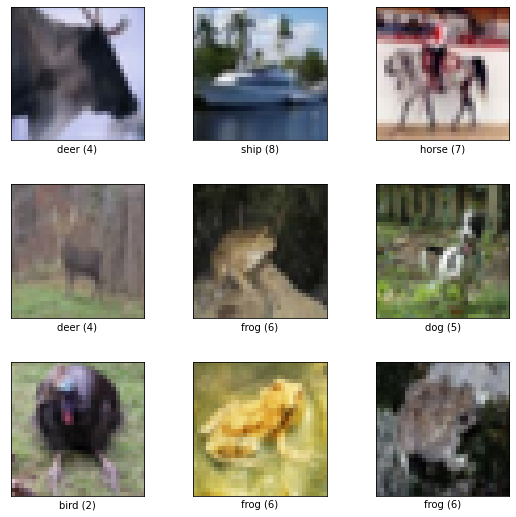

In [7]:
fig = tfds.show_examples(ds_train, ds_info)

## 2. 블록 구성하기
---

### Conv Block

In [8]:
def conv_block(layer, filters, kernel_size, strides=1, name='0'):
    
    conv_name = 'conv_' + str(name)
    batch_name = 'batch_' + str(name)
    act_name = 'act_' + str(name)
    
    x = keras.layers.Conv2D(filters=filters,
                           kernel_size=kernel_size,
                           kernel_initializer=glorot_uniform(seed=0),
                           padding='same',
                           strides=strides,
                           name=conv_name)(layer)
    
    x = keras.layers.BatchNormalization(name=batch_name)(x)
    x = keras.layers.Activation('sigmoid', name=act_name)(x)
    
    return x
               

### Residual block

In [9]:
def residual_block(layer, block, cnn, channel, is_50):
    x = layer
    
    if is_50:
        for i in range(cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1, 1), strides=2, name=f'shortcut_{block}_{i}')
                x = conv_block(x, channel, (1,1), strides=2, name=f'{block}_{i}_1')
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_2')
                x = conv_block(x, channel * 4, (1,1), name=f'{block}_{i}_3')
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1), strides=1, name=f'{block}_{i}_1')
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_2')
                x = conv_block(x, channel * 4, (1,1), strides=1, name=f'{block}_{i}_3')
            x = keras.layers.Add(name=f'shortcut_add_{block}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block}_{i}')(x)
    
    else:
        for i in range(cnn):
            if i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, name=f'shortcut_{block}_{i}')
                x = conv_block(x, channel, (3,3), strides=2, name=f'{block}_{i}_1')
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_2')
            
            else: 
                shortcut = x
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_1')
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_2')
            x = keras.layers.Add(name=f'shortcut_add_{block}_{i}')([x, shortcut])
            x=  keras.layers.Activation('relu', name=f'shortcut_act_{block}_{i}')(x)
            
    return x

### Plain Block

In [10]:
def plain_block(layer, block, cnn, channel, is_50):
    x = layer
    
    if is_50:
        for i in range(cnn):
            if i == 0:
                x = conv_block(x, channel, (1,1), strides=2, name=f'{block}_{i}_1')
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_2')
                x = conv_block(x, channel * 4, (1,1), name=f'{block}_{i}_3')
            else:
                x = conv_block(x, channel, (1,1), strides=1, name=f'{block}_{i}_1')
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_2')
                x = conv_block(x, channel * 4, (1,1), strides=1, name=f'{block}_{i}_3')

    else:
         for i in range(cnn):
            if i == 0:
                x = conv_block(x, channel, (3,3), strides=2, name=f'{block}_{i}_1')
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_2')
            
            else: 
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_1')
                x = conv_block(x, channel, (3,3), strides=1, name=f'{block}_{i}_2')

    return x

## 3. Resnet
---

In [11]:
def build_resnet(input_shape=(224,224,3), is_50=True, name='ResNet_50'):
    
    cnn_list = [3, 4, 6, 3]
    channel_list = [64, 128, 256, 512]
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    conv1 = conv_block(input_layer, 64, (7,7), strides=2, name='conv_first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    for block, (cnn, channel) in enumerate(zip(cnn_list, channel_list)):
        res = residual_block(res, block, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=0), name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)

    return model    

### ResNet_34

In [12]:
resnet_34 = build_resnet(is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_conv_first (Conv2D)        (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_conv_first (BatchNormaliz (None, 112, 112, 64) 256         conv_conv_first[0][0]            
__________________________________________________________________________________________________
act_conv_first (Activation)     (None, 112, 112, 64) 0           batch_conv_first[0][0]           
__________________________________________________________________________________________

### ResNet_50

In [13]:
resnet_50 = build_resnet()
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_conv_first (Conv2D)        (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_conv_first (BatchNormaliz (None, 112, 112, 64) 256         conv_conv_first[0][0]            
__________________________________________________________________________________________________
act_conv_first (Activation)     (None, 112, 112, 64) 0           batch_conv_first[0][0]           
__________________________________________________________________________________________

## 4. Plain  Network

In [14]:
def build_plain(input_shape=(224,224,3), is_50=True, name=None):
    
    cnn_list = [3, 4, 6, 3]
    channel_list = [64, 128, 256, 512]
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    conv1 = conv_block(input_layer, 64, (7,7), strides=2, name='conv_first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    for block, (cnn, channel) in enumerate(zip(cnn_list, channel_list)):
        plain = plain_block(plain, block, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=0))(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

### Plain_34 / Plain_50

In [15]:
plain_34 = build_plain(is_50=False, name='Plain_34')

plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_conv_first (Conv2D)     (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_conv_first (BatchNorma (None, 112, 112, 64)      256       
_________________________________________________________________
act_conv_first (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_0_1 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_0_0_1 (BatchNormalizat (None, 28, 28, 64)        256

In [16]:
plain_50 = build_plain()

plain_50.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_conv_first (Conv2D)     (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_conv_first (BatchNorma (None, 112, 112, 64)      256       
_________________________________________________________________
act_conv_first (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_0_1 (Conv2D)          (None, 28, 28, 64)        4160      
_________________________________________________________________
batch_0_0_1 (BatchNormalizat (None, 28, 28, 64)       

## 5. ResNet vs Plain Network
---

### 데이터셋: 'cats and dogs'로 변경

In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [18]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [19]:
BATCH_SIZE = 32
EPOCH = 20

In [20]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

ds_train

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [21]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.1)

### ResNet_34 학습

In [21]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy'],
)

history_res_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=ds_info.splits['train'].num_examples * 0.8//BATCH_SIZE,
    validation_steps=ds_info.splits['train'].num_examples * 0.8//BATCH_SIZE,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[reduce_lr]
)

Epoch 1/20
  2/581 [..............................] - ETA: 28s - loss: 20.5707 - accuracy: 0.5156WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0374s vs `on_train_batch_end` time: 0.0596s). Check your callbacks.


581/581 [==============================] - 78s 134ms/step - loss: 12.4829 - accuracy: 0.5075 - val_loss: 0.8275 - val_accuracy: 0.5137
Epoch 2/20
581/581 [==============================] - 59s 102ms/step - loss: 2.1071 - accuracy: 0.5356 - val_loss: 0.8034 - val_accuracy: 0.5206
Epoch 3/20
581/581 [==============================] - 60s 102ms/step - loss: 1.3827 - accuracy: 0.5524 - val_loss: 0.8210 - val_accuracy: 0.5816
Epoch 4/20
581/581 [==============================] - 60s 103ms/step - loss: 1.0836 - accuracy: 0.5617 - val_loss: 1.1548 - val_accuracy: 0.5127
Epoch 5/20
581/581 [==============================] - 59s 102ms/step - loss: 1.0685 - accuracy: 0.5687 - val_loss: 1.2339 - val_accuracy: 0.4880
Epoch 6/20
581/581 [==============================] - 59s 102ms/step - loss: 0.9229 - accuracy: 0.5987 - val_loss: 1.5210 - val_accuracy: 0.4895
Epoch 7/20
581/581 [==============================] - 60s 103ms/step - loss: 0.8240 - accuracy: 0.6331 - val_loss: 1.0002 - val_accuracy: 0.

### ResNet_50 학습

In [22]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy'],
)

history_res_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=ds_info.splits['train'].num_examples * 0.8//BATCH_SIZE,
    validation_steps=ds_info.splits['train'].num_examples * 0.8//BATCH_SIZE,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[reduce_lr]
)

Epoch 1/20
581/581 [==============================] - 94s 161ms/step - loss: 62.0017 - accuracy: 0.5001 - val_loss: 14.5064 - val_accuracy: 0.5108
Epoch 2/20
581/581 [==============================] - 109s 188ms/step - loss: 9.6001 - accuracy: 0.5025 - val_loss: 13.7439 - val_accuracy: 0.5099
Epoch 3/20
581/581 [==============================] - 85s 146ms/step - loss: 4.1331 - accuracy: 0.5206 - val_loss: 3.0783 - val_accuracy: 0.5108
Epoch 4/20
581/581 [==============================] - 85s 146ms/step - loss: 2.8009 - accuracy: 0.5448 - val_loss: 0.7481 - val_accuracy: 0.5748
Epoch 5/20
581/581 [==============================] - 85s 146ms/step - loss: 2.1242 - accuracy: 0.5491 - val_loss: 1.3287 - val_accuracy: 0.4986
Epoch 6/20
581/581 [==============================] - 85s 146ms/step - loss: 1.1706 - accuracy: 0.5841 - val_loss: 0.8076 - val_accuracy: 0.5803
Epoch 7/20
581/581 [==============================] - 85s 146ms/step - loss: 1.0502 - accuracy: 0.5910 - val_loss: 0.9739 - va

### Plain_34 학습

In [22]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=ds_info.splits['train'].num_examples * 0.8//BATCH_SIZE,
    validation_steps=ds_info.splits['train'].num_examples * 0.8//BATCH_SIZE,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[reduce_lr]
)

Epoch 1/20
  2/581 [..............................] - ETA: 26s - loss: 0.8044 - accuracy: 0.4219WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0342s vs `on_train_batch_end` time: 0.0565s). Check your callbacks.


581/581 [==============================] - 61s 104ms/step - loss: 1.1739 - accuracy: 0.5018 - val_loss: 0.6981 - val_accuracy: 0.4917
Epoch 2/20
581/581 [==============================] - 67s 116ms/step - loss: 0.9181 - accuracy: 0.5011 - val_loss: 0.7665 - val_accuracy: 0.4918
Epoch 3/20
581/581 [==============================] - 56s 96ms/step - loss: 0.8354 - accuracy: 0.5085 - val_loss: 0.8407 - val_accuracy: 0.4883
Epoch 4/20
581/581 [==============================] - 56s 96ms/step - loss: 0.8198 - accuracy: 0.4999 - val_loss: 0.8411 - val_accuracy: 0.4866
Epoch 5/20
581/581 [==============================] - 56s 96ms/step - loss: 0.7823 - accuracy: 0.5067 - val_loss: 0.7063 - val_accuracy: 0.5094
Epoch 6/20
581/581 [==============================] - 56s 96ms/step - loss: 0.7295 - accuracy: 0.5525 - val_loss: 0.8508 - val_accuracy: 0.5105
Epoch 7/20
581/581 [==============================] - 56s 96ms/step - loss: 0.7170 - accuracy: 0.5754 - val_loss: 0.6578 - val_accuracy: 0.5897
E

### Plain_50 학습

In [23]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=ds_info.splits['train'].num_examples * 0.8//BATCH_SIZE,
    validation_steps=ds_info.splits['train'].num_examples * 0.8//BATCH_SIZE,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[reduce_lr]
)

Epoch 1/20
581/581 [==============================] - 98s 169ms/step - loss: 6.7989 - accuracy: 0.4983 - val_loss: 0.8501 - val_accuracy: 0.4877
Epoch 2/20
581/581 [==============================] - 69s 118ms/step - loss: 1.5968 - accuracy: 0.5048 - val_loss: 0.7599 - val_accuracy: 0.4897
Epoch 3/20
581/581 [==============================] - 69s 119ms/step - loss: 1.1739 - accuracy: 0.5150 - val_loss: 1.5641 - val_accuracy: 0.5107
Epoch 4/20
581/581 [==============================] - 69s 119ms/step - loss: 0.9667 - accuracy: 0.5320 - val_loss: 0.6936 - val_accuracy: 0.4886
Epoch 5/20
581/581 [==============================] - 69s 119ms/step - loss: 0.8675 - accuracy: 0.5470 - val_loss: 2.1127 - val_accuracy: 0.4893
Epoch 6/20
581/581 [==============================] - 71s 122ms/step - loss: 0.9406 - accuracy: 0.5483 - val_loss: 0.9170 - val_accuracy: 0.4931
Epoch 7/20
581/581 [==============================] - 69s 119ms/step - loss: 0.8356 - accuracy: 0.5575 - val_loss: 1.2392 - val_ac

## 6. 비교

### Val_Accuracy

In [25]:
plt.plot(history_res_34.history['val_accuracy'], 'b')
plt.plot(history_res_50.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'y')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'])
plt.show()

NameError: name 'history_res_34' is not defined

### Val_Loss

In [ ]:
plt.plot(history_res_34.history['val_loss'], 'b')
plt.plot(history_res_50.history['val_loss'], 'g')
plt.plot(history_plain_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'y')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'])
plt.show()

### Report

- 학습이 너무 오래 걸리고 resnet의 특징이 잘 드러나지 못함
- WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time 뜨는 이유를 알 수 없음